<a href="https://colab.research.google.com/github/Gaoshan-Pan/Final_work/blob/main/Sales_foreasting_using_superstore_retail_Part2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting of Sales in the Retail Domain



In [2]:
# Install a binary compatible package with pmdarima
!pip install "numpy<2.0" "pmdarima==2.0.3"  # 2.0.3 is the current stable and compiled version on PyPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Restart the kernel and then run import

In [1]:
# All imports
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## Load dataset <a name="data_understanding__load_dataset" id="data_understanding__load_dataset"></a>

In [2]:
import kagglehub
rohitsahoo_sales_forecasting_path = kagglehub.dataset_download('rohitsahoo/sales-forecasting')

print('Import is completed.')


Import is completed.


In [3]:
# Load the dataset
df=pd.read_csv('/kaggle/input/sales-forecasting/train.csv')
# Link to Dataset on Kaggle: Superstore Sales Dataset: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/

## Follow the previous part1 and data pre-processing before sales forecasting


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [5]:
# ── Missing-value summary ────────────────────────────────────────────────
total_na   = df.isna().sum().sum()
by_column  = df.isna().sum().sort_values(ascending=False)

print(f"Total missing values in entire DataFrame: {total_na}\n")
print("Missing values by column:")
display(by_column)          # In a notebook, displays a neat Series table


Total missing values in entire DataFrame: 11

Missing values by column:


,0
Postal Code,11
Row ID,0
Order ID,0
Product Name,0
Sub-Category,0
Category,0
Product ID,0
Region,0
State,0
City,0


## Handle with missing/null values and non-meaningful data


In [6]:
# ── Handle missing / null values ─────────────────────────────────────────────
# Only a tiny share of the dataset, we can safely remove those rows instead of imputing them.
df = df.dropna(subset=["Postal Code"])
df.shape
# ── Remove features that add no value or raise privacy concerns ──────────────
# 1. 'Row ID' is simply a unique identifier, so it does not contribute
#    useful information for analysis or modelling.
df.drop("Row ID", axis="columns", inplace=True)

# 2. 'Customer Name' is omitted to minimise the risk of exposing
#    personally identifiable information during processing.
df.drop("Customer Name", axis="columns", inplace=True)

<ipython-input-6-25ab62299d90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Row ID", axis="columns", inplace=True)
<ipython-input-6-25ab62299d90>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Customer Name", axis="columns", inplace=True)


## Data conversion-Convert column data types


In [7]:
# 1. Parse the order date strings into true datetime objects.
df["Order Date"] = pd.to_datetime(df["Order Date"],
                                  format="%d/%m/%Y",   # adjust if needed
                                  errors="raise")       # stop if a value is malformed

# 2. Convert the shipping dates; treat any impossible values as missing.
df["Ship Date"] = pd.to_datetime(df["Ship Date"], errors="coerce")

# 3. Cast to a nullable integer so NAs are still allowed.
df["Postal Code"] = df["Postal Code"].astype("Int64")

# 4. Change string-like columns with a limited set of distinct values
#    to the 'category' dtype to save memory and speed up grouping.
cat_cols = [
    "Ship Mode", "Segment", "Country", "City",
    "State", "Region", "Category", "Sub-Category"
]

df[cat_cols] = df[cat_cols].astype("category")


In [8]:
# Convert all categorical features from object type to category type
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['Country'] = df['Country'].astype('category')
df['City'] = df['City'].astype('category')
df['State'] = df['State'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 0 to 9799
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      9789 non-null   object        
 1   Order Date    9789 non-null   datetime64[ns]
 2   Ship Date     3811 non-null   datetime64[ns]
 3   Ship Mode     9789 non-null   category      
 4   Customer ID   9789 non-null   object        
 5   Segment       9789 non-null   category      
 6   Country       9789 non-null   category      
 7   City          9789 non-null   category      
 8   State         9789 non-null   category      
 9   Postal Code   9789 non-null   Int64         
 10  Region        9789 non-null   category      
 11  Product ID    9789 non-null   object        
 12  Category      9789 non-null   category      
 13  Sub-Category  9789 non-null   category      
 14  Product Name  9789 non-null   object        
 15  Sales         9789 non-null   float64      

## Sort by Order Date in order to do sales forecasting


In [10]:
# Sort by Order Date
df.sort_values(by=['Order Date'], inplace=True)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
7980,CA-2015-103800,2015-01-03,2015-07-01,Standard Class,DP-13000,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
741,CA-2015-112326,2015-01-04,2015-08-01,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
740,CA-2015-112326,2015-01-04,2015-08-01,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
739,CA-2015-112326,2015-01-04,2015-08-01,Standard Class,PO-19195,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
1759,CA-2015-141817,2015-01-05,2015-12-01,Standard Class,MB-18085,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


From data decription before, we know this time line is from 2015-01-03 to 2018-12-30

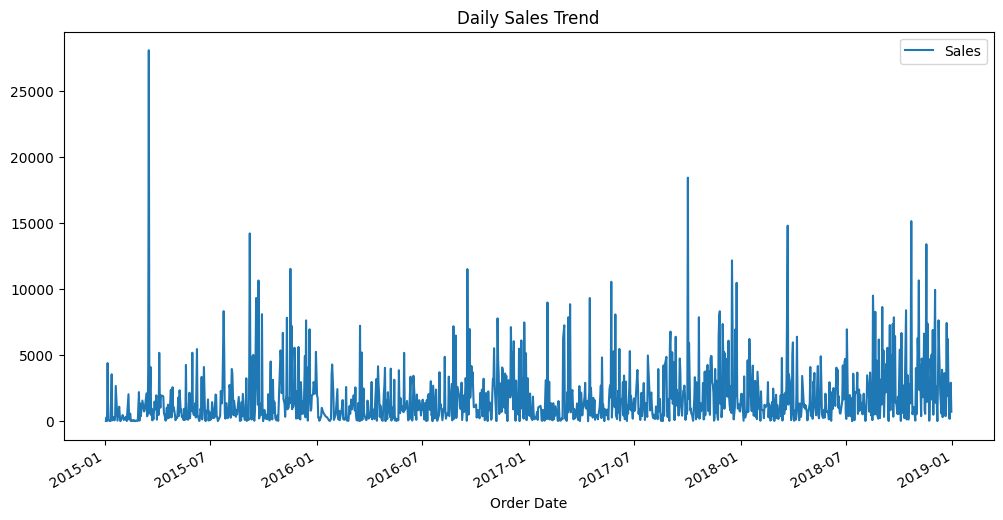

In [11]:
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# Aggregate sales by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.set_index('Order Date')
daily_sales.plot(figsize=(12, 6))
plt.title("Daily Sales Trend")
plt.show()

<ipython-input-12-9788b3f55dae>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.resample('M').sum()


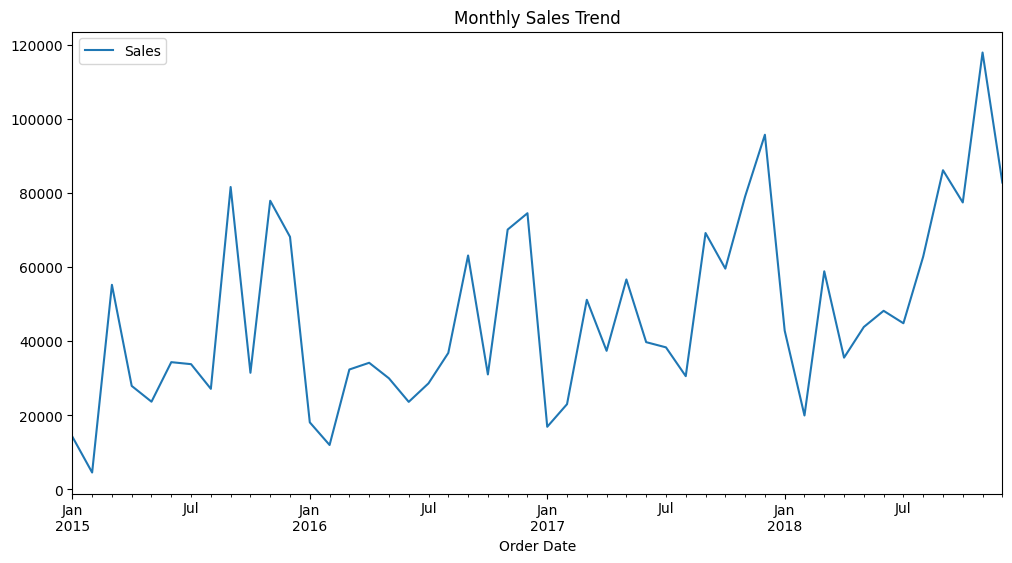

In [12]:
# Resample to monthly sales
monthly_sales = daily_sales.resample('M').sum()
monthly_sales.plot(figsize=(12, 6))
plt.title("Monthly Sales Trend")
plt.show()

# Part2-sales forecasting


##Simple Chronological Split
Training: Earliest 60-70% of dates
(Discover long-term trends and patterns)
​​Validation​​: Subsequent 15-20% of dates (Affect hyperparameters and identify overfitting)
​​Testing​​: Remains 15-20% of dates (Last unbiased test, replicating real deployment scenario)

| Block          | Period                      | Length | Why it works                                                                                       |
| -------------- | --------------------------- | ------ | -------------------------------------------------------------------------------------------------- |
| **Train**      | 2015-01-31 → **2017-06-30** | 30 mo  | 2½ years gives the model two full seasonal cycles and plenty of data to learn the trend.           |
| **Validation** | 2017-07-31 → **2018-06-30** | 12 mo  | Exactly one calendar year to tune hyper-parameters, so Christmas / New-Year peaks are represented. |
| **Test**       | 2018-07-31 → **2018-12-31** | 6 mo   | A completely unseen half-year for the final score and charts.                                      |


YUanma

In [13]:
# Since this is a time-series forecasting problem, the data should be split by past dates to train on, and future dates to predict. So I will use data from the years 2015 to 2017 for training, and use the data of the year 2018 for validation and testing (6 months for each)
train_start = pd.to_datetime('2015-01-31')  #using the last date of the month, since the grouping will be done by month
train_end = pd.to_datetime('2017-6-30')
validate_start = pd.to_datetime('2017-07-31')
validate_end = pd.to_datetime('2018-06-30')
test_start = pd.to_datetime('2018-07-31')
test_end = pd.to_datetime('2018-12-31')

In [59]:
# Time series data must be structured into a sequence of input-output pairs for LSTM models in such a way that each input is a
# fixed-length window of consecutive time steps (e.g., 12 months) and its corresponding output is the subsequent immediate value
# in the sequence. This sliding window approach creates sets of training samples in which months 1-12 are employed for predicting
# month 13, months 2-13 for predicting month 14, etc., in order to allow the model to learn temporal relationships among rolling
# time frames. To improve efficiency, we create a reusable function that systematically produces these input-label pairs such that
# equal preprocessing is applied in both initial model training and subsequent model retraining sessions. This structured change preserves
# the temporal relations within the data while enabling the LSTM to effectively extract and use time-dependent trends towards accurate prediction.

def create_sequences_for_lstm(data, window_size):
    training_seq_series = []
    training_label_series = []
    for i in range(len(data) - window_size - 1):
        training_seq = data[i:(i + window_size)]
        training_label = data[i + window_size]
        training_seq_series.append(training_seq)
        training_label_series.append(training_label)
    return np.array(training_seq_series), np.array(training_label_series)

# This function splits the time series data into training, validation, and testing sets based on specified date ranges.
# It uses the sequenced inputs/labels and the original date column to calculate index-based slicing.

def split(date_column,
          sequencedX, sequencedY,
          train_start_date, train_end_date,
          validate_start_date, validate_end_date,
          test_start_date, test_end_date,
          window_size):

    training_size = int(np.sum((date_column >= train_start_date) & (date_column <= train_end_date)) - window_size - 1)
    validation_size = int(np.sum((date_column >= validate_start_date) & (date_column <= validate_end_date)))

    X_training = sequencedX[:training_size]
    y_training = sequencedY[:training_size]
    X_validation = sequencedX[training_size:training_size+validation_size]
    y_validation = sequencedY[training_size:training_size+validation_size]
    X_testing = sequencedX[training_size+validation_size:]
    y_testing = sequencedY[training_size+validation_size:]

    return X_training, y_training, X_validation, y_validation, X_testing, y_testing

# LSTM input format must be 3D: [samples, time steps, features]. This reshapes the data accordingly.
def reshape(X_training, X_validation, X_testing):
    X_training = np.reshape(X_training, (X_training.shape[0], X_training.shape[1], 1))
    X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
    X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

    return X_training, X_validation, X_testing

# Visualizes the training and validation loss across epochs for model performance monitoring.
def plot_training_validation_loss(model_history, round_number, title_override=None):
    plt.figure(figsize=(8, 5))
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    if title_override is not None:
        plt.title(title_override)
    else:
        plt.title('Exp' + round_number + ': Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Generates sales predictions on a given dataset, reverses the scaling to restore original values, and calculates RMSE.
def predict_sales(model, X_data, y_labels, scaler):
    predicted_sales = model.predict(X_data)
    unscaled_predictions = scaler.inverse_transform(predicted_sales)
    unscaled_labels = scaler.inverse_transform(y_labels.reshape(-1, 1))
    rmse = sqrt(root_mean_squared_error(unscaled_labels, unscaled_predictions))
    return unscaled_predictions, unscaled_labels, rmse

# This function plots original sales data alongside predicted values from training and validation phases to compare performance visually.
def plot_training_and_validation_time_series_lstm(dataframe, date_column_name, sales_column_name,
                                                predicted_sales_on_training, predicted_sales_on_validation,
                                                scaler, title):
    # Set custom style
    plt.style.use('ggplot')

    plt.figure(figsize=(15, 5), facecolor='#f5f5f5')

    # Create empty arrays for plotting
    training_plot_array = np.empty_like(dataframe[sales_column_name])
    training_plot_array[:] = np.nan
    training_plot_array[window:len(predicted_sales_on_training)+window] = predicted_sales_on_training.flatten()

    starting_index = len(predicted_sales_on_training) + window
    ending_index = starting_index + len(predicted_sales_on_validation)

    validation_plot_array = np.empty_like(dataframe[sales_column_name])
    validation_plot_array[:] = np.nan
    validation_plot_array[starting_index:ending_index] = predicted_sales_on_validation.flatten()

    # Plot with custom styling
    plt.plot(dataframe[date_column_name],
             scaler.inverse_transform(dataframe[[sales_column_name]]),
             color='#2c3e50',
             linewidth=2.5,
             linestyle='-',
             alpha=0.9,
             label="Original Data")

    plt.plot(dataframe[date_column_name],
             training_plot_array,
             color='#e74c3c',
             linewidth=2,
             linestyle='--',
             alpha=0.8,
             label="Training Predictions")

    plt.plot(dataframe[date_column_name],
             validation_plot_array,
             color='#27ae60',
             linewidth=2,
             linestyle='-.',
             alpha=0.8,
             label="Validation Predictions")

    # Customize plot appearance
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.legend(framealpha=0.9, facecolor='white', edgecolor='#333333')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')

    plt.tight_layout()
    plt.show()


# # Displays predicted and actual sales on the test dataset along a date axis, with formatting options for tick labels and layout.
def plot_testing_time_series_lstm(dataframe, date_column_name,
                                predicted_sales_on_testing,
                                y_labels_on_testing,
                                testing_start_date,
                                title,
                                x_axis_ticks_obj,
                                x_axis_ticks_formatter,
                                x_axis_ticks_rotation_angle):

    plt.figure(figsize=(12, 6), facecolor='#f8f9fa')

    test_data = dataframe[dataframe[date_column_name] >= testing_start_date]

    plt.plot(test_data[date_column_name], y_labels_on_testing,
            color='#3498db', linewidth=2.5, alpha=0.9,
            label='Actual Sales', marker='o', markersize=4)

    plt.plot(test_data[date_column_name], predicted_sales_on_testing,
            color='#e74c3c', linewidth=2, linestyle='--',
            alpha=0.8, label='Predicted Sales', marker='^', markersize=5)

    plt.xlabel('Date', fontsize=12, labelpad=10)
    plt.ylabel('Sales', fontsize=12, labelpad=10)
    plt.gca().xaxis.set_major_locator(x_axis_ticks_obj)

    if x_axis_ticks_formatter is not None:
        plt.gca().xaxis.set_major_formatter(x_axis_ticks_formatter)

    plt.xticks(rotation=x_axis_ticks_rotation_angle, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.legend(framealpha=1, facecolor='white', edgecolor='#95a5a6',
              fontsize=10, frameon=True)

    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [15]:
# For time-series forecasting, only two columns are needed: Order Date and Sales.
df_round1 = df[['Order Date', 'Sales']].rename(columns={'Order Date': 'date', 'Sales': 'monthly_sales'})
df_round1['monthly_sales'] = df_round1['monthly_sales']

In [16]:
df_round1.head()

,date,monthly_sales
7980,2015-01-03,16.448
741,2015-01-04,3.540
740,2015-01-04,272.736
739,2015-01-04,11.784
1759,2015-01-05,19.536


In [17]:
# Index the dataframe by Order Date. This is needed to be able to resample (group) by the Order Date
df_round1.set_index('date', inplace = True)
df_round1.head()

,monthly_sales
date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536


In [18]:
# Group by monthly sales and aggregate by SUM
df_round1 = df_round1.resample('ME')['monthly_sales'].sum().reset_index()  # Note: "ME" stands for "Month End"
df_round1.head()

,date,monthly_sales
0,2015-01-31,14205.707
1,2015-02-28,4519.892
2,2015-03-31,55205.797
3,2015-04-30,27906.855
4,2015-05-31,23644.303


In [19]:
df_round1.tail()

,date,monthly_sales
43,2018-08-31,62837.8480
44,2018-09-30,86152.8880
45,2018-10-31,77448.1312
46,2018-11-30,117938.1550
47,2018-12-31,82825.3588


In [20]:
# Use MinMaxScaler to scale the Sales to a value between 0 and 1  (i.e. from 0% to 100%)
minMaxScaler1 = MinMaxScaler()
df_round1['monthly_sales'] = minMaxScaler1.fit_transform(df_round1[['monthly_sales']])
print(df_round1['monthly_sales'].min(), df_round1['monthly_sales'].max())

0.0 0.9999999999999999


In [21]:
# Use the sequencer utility function to obtain data and labels (i.e. true values to use for supervised learning)
window = 12
X, y = create_sequences_for_lstm(df_round1['monthly_sales'], window)

In [22]:
# Split data into training, validation, and testing by the dates specified above. Start by flagging the respective rows with "True"
train_indices1 = (df_round1['date'] >= train_start) & (df_round1['date'] <= train_end)
validate_indices1 = (df_round1['date'] >= validate_start) & (df_round1['date'] <= validate_end)
test_indices1 = (df_round1['date'] >= test_start) & (df_round1['date'] <= test_end)

In [23]:
# Determine the size of each partition by counting how many rows were marked with True in the previous step
train_size1 = int(np.sum(train_indices1) - window - 1) #note: subtracting 12 because the first 12 months are the first chunk of training data, nothing came before them in the sequence. In other words, the labels start from month 13 onwards.
validate_size1 = int(np.sum(validate_indices1))
#test_size1 = int(np.sum(test_indices1))

In [24]:
# Do the actual splitting, as per the division specified above.
X_train = X[:train_size1]
y_train = y[:train_size1]
X_validate = X[train_size1:train_size1+validate_size1]
y_validate = y[train_size1:train_size1+validate_size1]
X_test = X[train_size1+validate_size1:]
y_test = y[train_size1+validate_size1:]

In [25]:
# LSTM requires the input to be shaped into a 3D format.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validate = np.reshape(X_validate, (X_validate.shape[0], X_validate.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)

(17, 12, 1)
(17,)
(12, 12, 1)
(12,)
(6, 12, 1)
(6,)


In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2

lstm_model_round1 = Sequential()
lstm_model_round1.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=l2(0.01)))
lstm_model_round1.add(Dropout(0.2))
lstm_model_round1.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
lstm_model_round1.add(Dropout(0.2))
lstm_model_round1.add(Dense(1))  # Regression output

lstm_model_round1.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Show model summary
lstm_model_round1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
epochs1 = 100
#epochs1 = 300 # trying an overly large number of epochs to forcibly see how/when early stopping will step in.
batch_size1 = 12
early_stopping_patience = 10
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience, restore_best_weights=True, verbose=1)

history1 = lstm_model_round1.fit(X_train, y_train,
                                 epochs=epochs1,
                                 batch_size=batch_size1,
                                 validation_data=(X_validate, y_validate),
                                 callbacks=[early_stopping],
                                 verbose=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - loss: 1.1787 - val_loss: 1.1936
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1024 - val_loss: 1.0972
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.0121 - val_loss: 1.0145
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.9662 - val_loss: 0.9449
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.9192 - val_loss: 0.8925
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.8769 - val_loss: 0.8535
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8471 - val_loss: 0.8180
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.8114 - val_loss: 0.7842
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7733 - val_loss: 0.7549
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.7389 - val_loss: 0.7300
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.7037 - val_loss: 0.7051
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.6829 - val_l

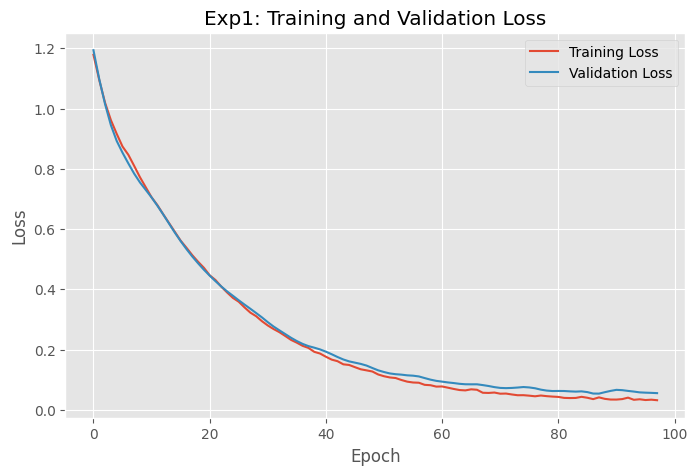

In [60]:
# Plot training and validation loss graph
plot_training_validation_loss(history1, '1')

In [31]:
# Predict Sales on TRAINING Data, then on VALIDATION Data, then on TEST Data

p_sales_training1, y_sales_training1, rmse_training1 = predict_sales(lstm_model_round1, X_train, y_train, minMaxScaler1)
p_sales_validation1, y_sales_validation1, rmse_validation1 = predict_sales(lstm_model_round1, X_validate, y_validate, minMaxScaler1)
p_sales_test1, y_sales_test1, rmse_test1 = predict_sales(lstm_model_round1, X_test, y_test, minMaxScaler1)

print()
print(f'RMSE on TRAINING Data: {rmse_training1}')
print(f'RMSE on VALIDATION Data: {rmse_validation1}')
print(f'RMSE on TEST Data: {rmse_test1}')
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

RMSE on TRAINING Data: 134.78306308042374
RMSE on VALIDATION Data: 153.72606152803334
RMSE on TEST Data: 200.07070393479745



In [32]:
# Compare the actual sales numbers with predicted ones
temp_peek_df1 = pd.DataFrame(np.concatenate((y_sales_test1, p_sales_test1), axis=1), columns=['Actual Sales', 'Predicted Sales'])
temp_peek_df1

,Actual Sales,Predicted Sales
0,48190.7277,40881.601562
1,44825.1040,41229.652344
2,62837.8480,41592.953125
3,86152.8880,42067.515625
4,77448.1312,41604.386719
5,117938.1550,41337.945312


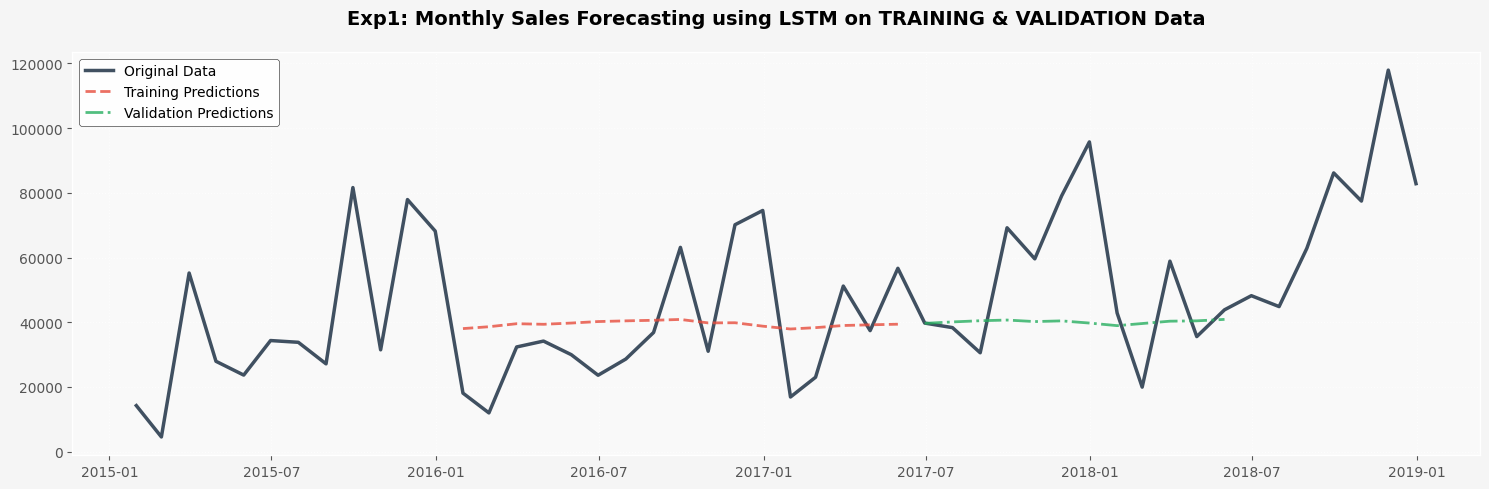

In [33]:
# Plot the results of prediction on TRAINING data and VALIDATION data
title = 'Exp1: Monthly Sales Forecasting using LSTM on TRAINING & VALIDATION Data'
plot_training_and_validation_time_series_lstm(df_round1, 'date', 'monthly_sales', p_sales_training1, p_sales_validation1, minMaxScaler1, title)

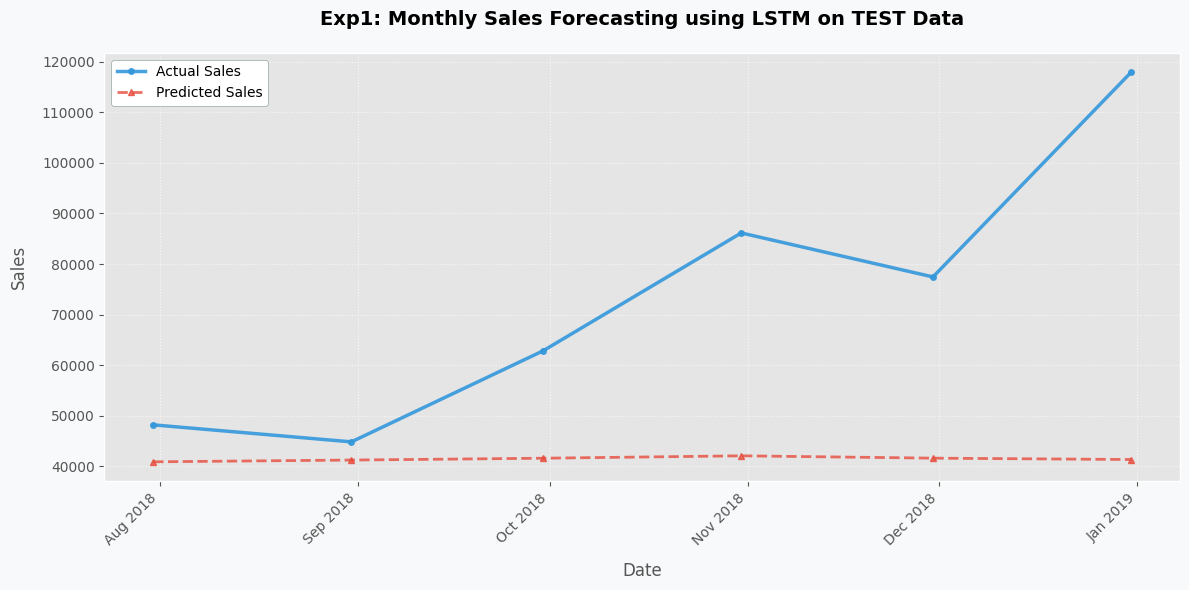

In [34]:
# Plot the results of prediction on TEST data
title = 'Exp1: Monthly Sales Forecasting using LSTM on TEST Data'
plot_testing_time_series_lstm(df_round1, 'date', p_sales_test1, y_sales_test1, test_start, title, mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)
# Note: it may appear that the months are starting from August, but that's because the dates are at the end of each month, so basically 2018-07-31 appears as if it is 2018-08-01, but if we closely examine the graph we'll notice that the line starts at a point that is slightly before the label of Aug2018 (i.e. the line starts at the last day of July).

# Experiment 2

 predict weekly sales instead of monthR3

In [50]:
df_round2 = df[['Order Date', 'Sales']]
df_round2 = df_round2.rename(columns={'Order Date': 'date', 'Sales': 'weekly_sales'})
df_round2.set_index('date', inplace = True)

# Group by weekly sales, and aggregate by SUM
df_round2 = df_round2.resample('W')['weekly_sales'].sum().reset_index()
df_round2.shape

(209, 2)

To maintains uniform weekly granularity for aggregations (e.g., weekly sales sums). And to prevent models from misinterpreting partial weeks as outliers or anomalies.

​SO, ​remove incomplete weeks​​ from the dataset


In [51]:
df_round2.drop(df_round2[df_round2['date'] <= '2015-01-04'].index, inplace=True)
df_round2.drop(df_round2[df_round2['date'] >= '2018-12-31'].index, inplace=True)
df_round2.shape

(208, 2)

In [52]:
minMaxScaler2 = MinMaxScaler()
df_round2['weekly_sales'] = minMaxScaler2.fit_transform(df_round2[['weekly_sales']])

window = 52
X2, y2 = create_sequences_for_lstm(df_round2['weekly_sales'], window)

Split the Data by Weeks. Second, Reshape for LSTM Input​, so convert the data into a ​​3D structure​​ ([samples, timesteps, features]) required for LSTM training.

In [53]:

train_start2 = pd.to_datetime('2015-01-11')
train_end2 = pd.to_datetime('2017-12-31')
validate_start2 = pd.to_datetime('2018-01-07')
validate_end2 = pd.to_datetime('2018-07-01')
test_start2 = pd.to_datetime('2018-07-08')
test_end2 = pd.to_datetime('2018-12-30')

X_train2, y_train2, X_validate2, y_validate2, X_test2, y_test2 = split(df_round2['date'], X2, y2, train_start2, train_end2, validate_start2, validate_end2, test_start2, test_end2, window)

X_train2, X_validate2, X_test2 = reshape(X_train2, X_validate2, X_test2)

Same model as previous

In [54]:

lstm_model_round2 = Sequential()
lstm_model_round2.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=l2(0.01)))
lstm_model_round2.add(Dropout(0.2))
lstm_model_round2.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
lstm_model_round2.add(Dropout(0.2))
lstm_model_round2.add(Dense(1))  # Regression output

lstm_model_round2.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Train the model
epochs2 = 100
batch_size2 = 12
early_stopping_patience2 = 10
early_stopping2 = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience2, restore_best_weights=True, verbose=1)

history2 = lstm_model_round2.fit(X_train2, y_train2,
                                 epochs=epochs2,
                                 batch_size=batch_size2,
                                 validation_data=(X_validate2, y_validate2),
                                 callbacks=[early_stopping2],
                                 verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 1.0581 - val_loss: 0.9093
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.8576 - val_loss: 0.7253
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.7011 - val_loss: 0.5916
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.5712 - val_loss: 0.4811
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.4630 - val_loss: 0.3871
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3761 - val_loss: 0.3130
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3032 - val_loss: 0.2512
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2508 - val_loss: 0.2033
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2024 - val_loss: 0.1635
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1579 - val_loss: 0.1318
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1291 - val_loss: 0.1101
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1130 - val_l

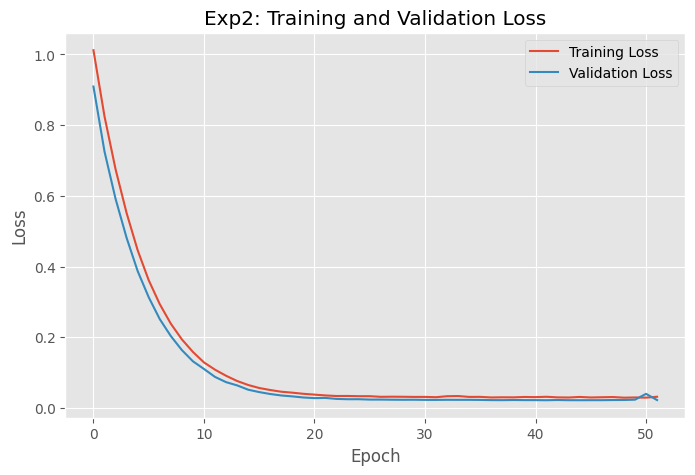

In [61]:
# Plot training and validation loss graph
plot_training_validation_loss(history2, '2')

delete exp2

In [57]:
p_sales_training2, y_sales_training2, rmse_training2 = predict_sales(lstm_model_round2, X_train2, y_train2, minMaxScaler2)
p_sales_validation2, y_sales_validation2, rmse_validation2 = predict_sales(lstm_model_round2, X_validate2, y_validate2, minMaxScaler2)
p_sales_test2, y_sales_test2, rmse_test2 = predict_sales(lstm_model_round2, X_test2, y_test2, minMaxScaler2)

print()
print(f'Exp2: RMSE on Training Data: {rmse_training2}')
print(f'Exp2: RMSE on Val Data: {rmse_validation2}')
print(f'Exp2: RMSE on Test Data: {rmse_test2}')
print()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Exp2: RMSE on Training Data: 79.08979773194467
Exp2: RMSE on Val Data: 72.8781297522365
Exp2: RMSE on Test Data: 100.17821537947299



In [58]:
temp_peek_df2 = pd.DataFrame(np.concatenate((y_sales_test2, p_sales_test2), axis=1), columns=['Actual Sales', 'Predicted Sales'])
temp_peek_df2

,Actual Sales,Predicted Sales
0,6318.9355,9795.937500
1,17261.1922,9844.340820
2,11589.8420,9893.015625
3,9998.8410,9926.316406
4,10896.3050,9953.833008
5,9618.8820,9965.821289
6,5205.6280,9932.747070
7,11128.5300,9911.908203
8,22222.5540,9981.679688
9,15330.0720,10065.850586


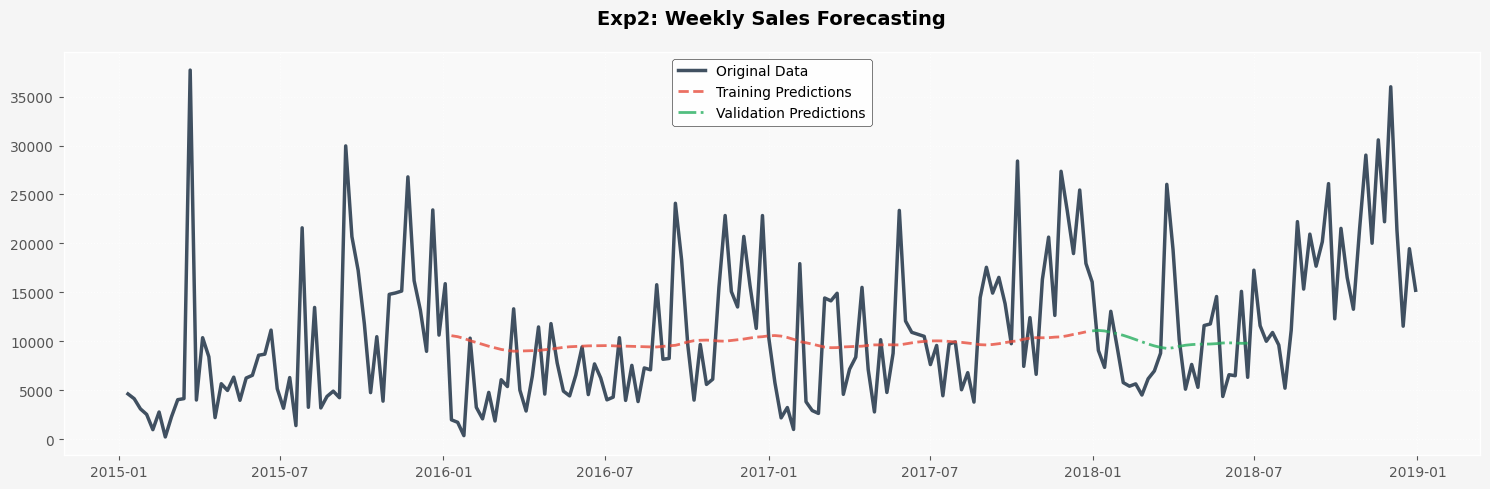

In [62]:
# Plot the results of prediction on TRAINING data and VALIDATION data
title = 'Exp2: Weekly Sales Forecasting'
plot_training_and_validation_time_series_lstm(df_round2, 'date', 'weekly_sales', p_sales_training2, p_sales_validation2, minMaxScaler2, title)

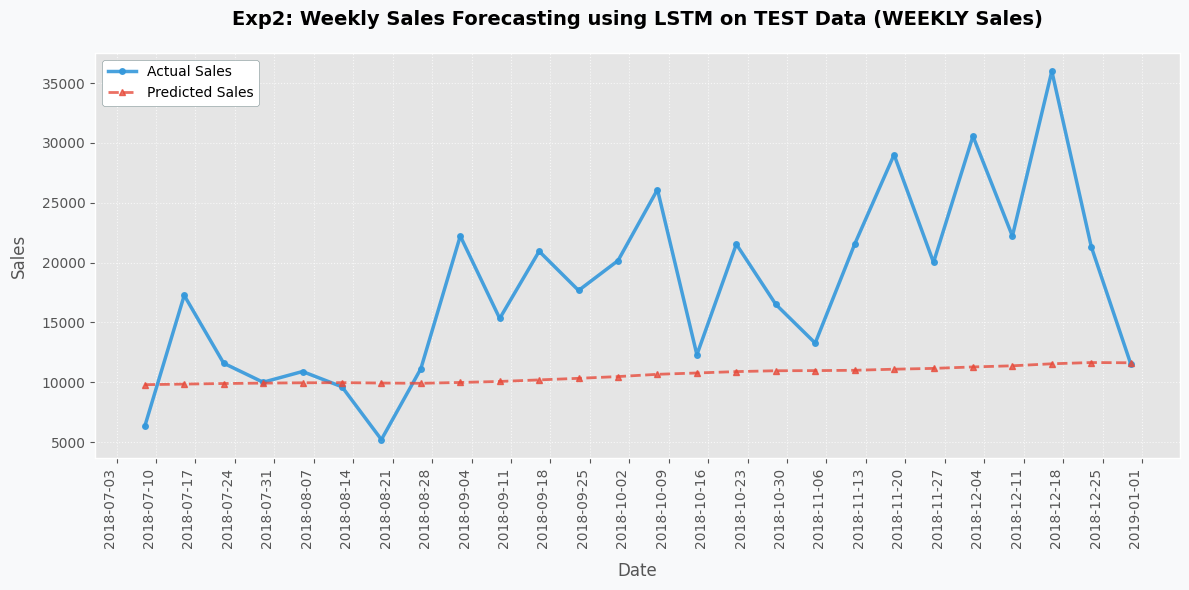

In [63]:
# Plot the results of prediction on TEST data
title = 'Exp2: Weekly Sales Forecasting using LSTM on TEST Data (WEEKLY Sales)'
plot_testing_time_series_lstm(df_round2, 'date', p_sales_test2, y_sales_test2, test_start2, title, mdates.WeekdayLocator(), None, 90)

**conclusion:**

At this phase of the analysis, I played around with whether forecast at a weekly level of sales data (as opposed to monthly) would more closely align with the forecasts. I hypothesized that additional granularity (weekly totals) might be capable of detecting more nuanced trends or seasonal influences that a monthly aggregate won't be capable of detecting.

**Key Observations from the Experiment:**
1. Weekly vs. Monthly Aggregation:
• Weekly Sales Data: Provided more data points (52 weeks/year compared to 12 months/year), potentially revealing short-term trends.

   • Monthly Sales Data: Smoothing out noise but potentially obscuring abrupt changes (e.g., holiday spikes, promotion impact).

2. Model Performance:
   • Despite the greater granularity, forecasts were still inaccurate, with variances similar to or worse than monthly totals.

• Possible explanations:
    
 ◦ Noise Amplification: Weekly data imposed volatility (e.g., random demand, outliers) without adding useful signal.
    
 ◦ Not Enough Historical Context: The model may need additional long-term trends (e.g., annual cycles) captured by monthlies.

◦ Model Constraints: The chosen model (for instance, LSTM, ARIMA) might struggle with high-frequency noise or be hyperparameter-sensitive.

3. Graphical Evidence:
   • Plots for predictions did not reveal any significant improvement with respect to actual sales.

   • Errors (for example, MAE, RMSE) were comparable or even higher than monthly outcomes, with no advantage for weekly splits.


**Next Steps:**
Since aggregation at the week level did not yield better accuracy, we'll go back to monthly sales data and explore other strategies, including:
• Feature Engineering: Include external variables (e.g., promotions, holidays, economic indicators).

• Model Tweaks:
  
  • Compare varied architectures
  
  • Hyperparameter tuning
  


**Conclusion:**
While weekly data offered no short-term benefit, this test points to the worth of experimenting with granularity levels and calibrating them in accordance with the model's capability. Future exps will focus on refining the monthly method while eliminating root noise and trend extraction.


# Experiment 3

In [64]:
#For detailed explanation of the steps, see detailed comments on code cells in Round 1
df_round4 = df[['Order Date', 'Sales']]
df_round4 = df_round4.rename(columns={'Order Date': 'date', 'Sales': 'monthly_sales'})
df_round4.set_index('date', inplace = True)


df_round4 = df_round4.resample('ME')['monthly_sales'].sum().reset_index()
df_round4.head()

,date,monthly_sales
0,2015-01-31,14205.707
1,2015-02-28,4519.892
2,2015-03-31,55205.797
3,2015-04-30,27906.855
4,2015-05-31,23644.303


In [65]:
minMaxScaler4 = MinMaxScaler()
df_round4['monthly_sales'] = minMaxScaler4.fit_transform(df_round4[['monthly_sales']])

window = 12
X4, y4 = create_sequences_for_lstm(df_round4['monthly_sales'], window)

In [66]:
# Data splition
X_train4, y_train4, X_validate4, y_validate4, X_test4, y_test4 = split(df_round4['date'], X4, y4, train_start, train_end, validate_start, validate_end, test_start, test_end, window)

# convert it to 3D
X_train4, X_validate4, X_test4 = reshape(X_train4, X_validate4, X_test4)

New network architecture

In [67]:
num_neurons4_layer1 = 100
num_neurons4_layer2 = 60
num_neurons4_layer3 = 30
num_neurons4_layer4 = 10
regularization = l2
regularization_factor = 0.01

lstm_model_round4 = Sequential()
lstm_model_round4.add(LSTM(num_neurons4_layer1,
                           input_shape=(X_train4.shape[1], 1),
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round4.add(LSTM(num_neurons4_layer2,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round4.add(LSTM(num_neurons4_layer3,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round4.add(LSTM(num_neurons4_layer4, kernel_regularizer=regularization(regularization_factor)))
lstm_model_round4.add(Dense(1))
lstm_model_round4.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_round4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 60)         │        38,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 12, 30)         │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,011 (359.42 KB)

 Trainable params: 92,011 (359.42 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train the model
epochs4 = 300
batch_size4 = 12
early_stopping_patience4 = 10
early_stopping4 = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience4, restore_best_weights=True, verbose=1)

history4 = lstm_model_round4.fit(X_train4, y_train4,
                                 epochs=epochs4,
                                 batch_size=batch_size4,
                                 validation_data=(X_validate4, y_validate4),
                                 callbacks=[early_stopping4],
                                 verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 2.6937 - val_loss: 2.6518
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.5595 - val_loss: 2.5251
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.4564 - val_loss: 2.4021
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.3446 - val_loss: 2.2858
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.2467 - val_loss: 2.1812
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.1575 - val_loss: 2.0914
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.0764 - val_loss: 2.0108
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.9971 - val_loss: 1.9361
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.9169 - val_loss: 1.8672
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.8444 - val_loss: 1.8020
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.7701 - val_loss: 1.7385
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.7047 - va

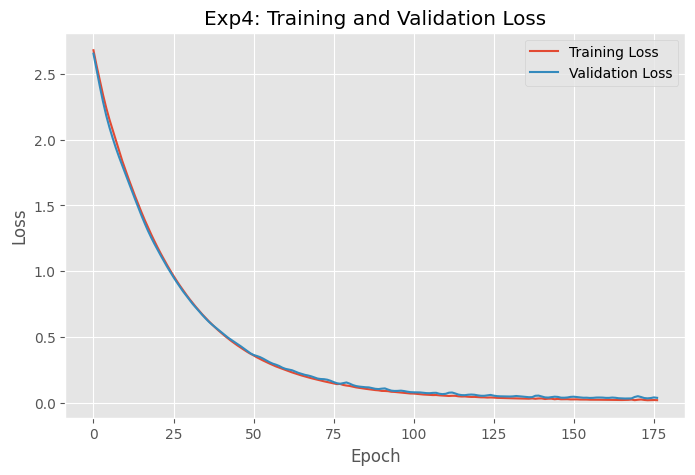

In [69]:
# Plot training and validation loss graph
plot_training_validation_loss(history4, '4')

In [71]:
# Predict Sales on TRAINING Data, then on VALIDATION Data, then on TEST Data

p_sales_training4, y_sales_training4, rmse_training4 = predict_sales(lstm_model_round4, X_train4, y_train4, minMaxScaler4)
p_sales_validation4, y_sales_validation4, rmse_validation4 = predict_sales(lstm_model_round4, X_validate4, y_validate4, minMaxScaler4)
p_sales_test4, y_sales_test4, rmse_test4 = predict_sales(lstm_model_round4, X_test4, y_test4, minMaxScaler4)

print()
print(f'Exp3: RMSE on TRAINING Data: {rmse_training4}')
print(f'Exp3: RMSE on VALIDATION Data: {rmse_validation4}')
print(f'Exp3: RMSE on TEST Data: {rmse_test4}')
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Exp3: RMSE on TRAINING Data: 117.1358464352687
Exp3: RMSE on VALIDATION Data: 133.8444481749776
Exp3: RMSE on TEST Data: 159.21421940500105



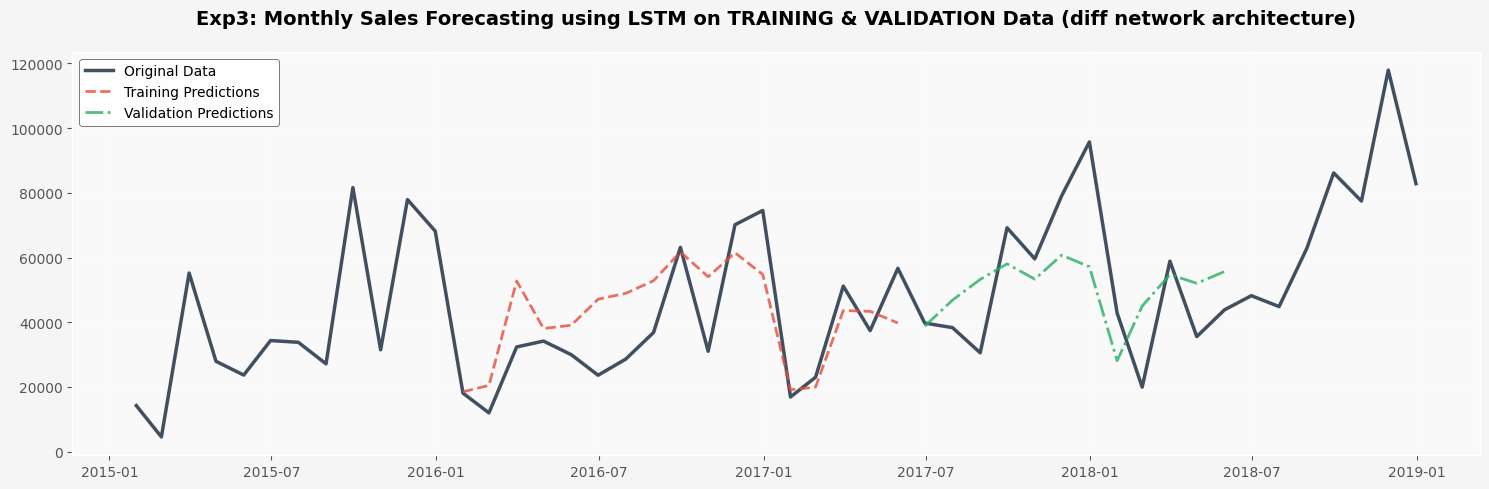

In [72]:
# Plot the results of prediction on TRAINING data and VALIDATION data
title = 'Exp3: Monthly Sales Forecasting using LSTM on TRAINING & VALIDATION Data (diff network architecture)'
plot_training_and_validation_time_series_lstm(df_round4, 'date', 'monthly_sales', p_sales_training4, p_sales_validation4, minMaxScaler4, title)

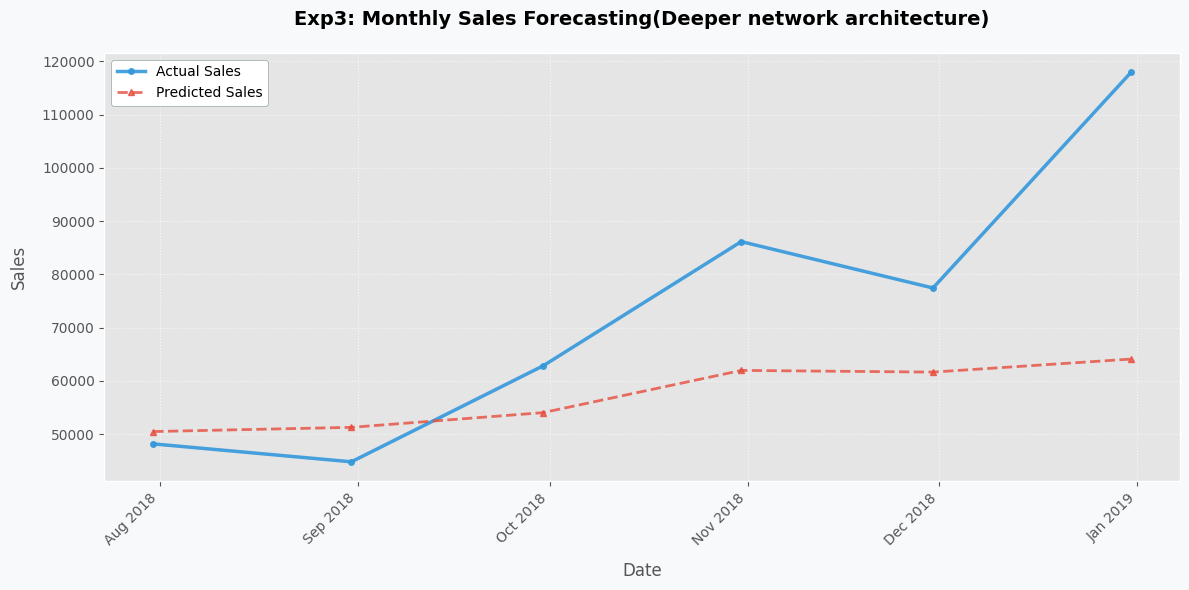

In [73]:
# Plot the results of prediction on TEST data
title = 'Exp3: Monthly Sales Forecasting(Deeper network architecture)'
plot_testing_time_series_lstm(df_round4, 'date', p_sales_test4, y_sales_test4, test_start, title, mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)

​​Detailed Analysis of Architectural Improvements and Their Impact on Model Performance​.
This experimental stage focused heavily on ​​optimizing the LSTM network architecture​​ and ​​training hyperparameters​​ to achieve better prediction accuracy. The improvements were:

​​1. Architectural Refinements​​
​​(a) Depth Increase in the Network

​​Previous Architecture:​​ 2 LSTM layers
​​New Architecture:​​ 4 LSTM layers
​​Reason:
More capable networks can resolve more complex temporal patterns between sequential data.
More layers facilitate hierarchical feature extraction—lower layers detect short-term patterns, and higher layers learn long-term trends.
(b) Neuron Varying Number per Layer

Neuron Distribution: 100 → 60 → 30 → 10
Reasoning:
Progressively lower-dimensional representation of temporal features is enabled by a decreasing neuron number that eliminates noise and retains informative patterns.
The architecture is similar to an autoencoder-like method, where generalization is supported through dimensionality reduction.
2. Modifications on the Training Process
Epochs from 50 → 300
Effect:
Lower loss values were achieved by the model with each epoch, indicating better optimization.
More training allowed the network to fine-tune weights more effectively, reducing prediction errors.
​​3. Performance Evaluation​​
​​(a) Trend Alignment Improvement​

​​Graphical Analysis:
The ​​predicted trend (orange line)​​ is now more in sync with the ​​actual sales (blue line)​​, particularly in detecting ​​peaks and troughs​​.
Although ​​absolute value accuracy​​ leaves much to be desired, the model better captures ​​when sales go up or down​​, which is priceless for decision-making.
​​(b) Loss Reduction​

​​Training Dynamics:
Loss curve showed consistent decreasing through epochs, that the model wasn't overfitting but learning instead.
No flattening revealed additional training (e.g., 300+) to yield additional gains.
​​4. Key Takeaways & What's Next​​
​​(a) Keep Current Architecture​

The ​​4-layer LSTM with diminishing neurons​​ was superior to the previous 2-layer setup.
Future experimentation may try:
​​Even deeper networks​​ (e.g., 5-6 layers) with skip connections to avoid vanishing gradients.
​​Alternative neuron distributions​​ (e.g., 128 → 64 → 32 → 16) for increased capacity.
​​(b) Explore Other Enhancements___

​​Data Preparation:__
Try alternative ​​lag windows​​ (e.g., 6-month versus 12-month lookbacks).
Add ​​external variables​​ (e.g., promotions, holidays) to provide more context.
​​Regularization:__
Add ​​dropout layers​​ or ​​L2 regularization​​ to prevent overfitting in deeper networks.
​​Alternative Models:__
Benchmark against ​​Transformer-based​​ models (e.g., Temporal Fusion Transformer) for potential gains.
​​Conclusion__()
This version demonstrated that ​​increased model complexity​​ (more layers, neurons, and epochs) significantly improved trend prediction, although overall absolute value prediction still needs to be perfected. Future versions will ​​utilize the effective architectural changes​​ while exploring complementary improvements in data engineering and model tuning.



##Experiment Design​​ 4

In this version, we introduce a ​​strategic improvement​​ to our forecasting methodology by adding ​​category-level analysis​​. Rather than ingesting all product sales combined, we divide the data into three categories:

​​Furniture​​
​​Office Supplies​​
​​Technology​​
This allows the model to ​​learn separate demand patterns​​ for each product type, which can improve forecast precision by picking up on category-specific trends and seasonality.



In [74]:
# Group by CATEGORY and by MONTHLY sales
df_round5 = df[['Order Date', 'Category', 'Sales']]
df_round5.set_index('Order Date', inplace = True)
df_round5 = df_round5.groupby(['Order Date','Category'], observed=False)['Sales'].sum().reset_index()
df_round5 = df_round5.set_index(['Order Date', 'Category']).unstack('Category').fillna(0)
df_round5.columns = df_round5.columns.levels[1].rename(None)
df_round5 = df_round5.resample('ME').sum().reset_index()

In [75]:
# break the data into 3 separate dataframes, one for each category of sales
df_round5_f = df_round5[['Order Date', 'Furniture']]
df_round5_s = df_round5[['Order Date', 'Office Supplies']]
df_round5_t = df_round5[['Order Date', 'Technology']]

In [76]:
minMaxScaler5_f = MinMaxScaler()
minMaxScaler5_s = MinMaxScaler()
minMaxScaler5_t = MinMaxScaler()

df_round5_f['Furniture'] = minMaxScaler5_f.fit_transform(df_round5_f[['Furniture']])
df_round5_s['Office Supplies'] = minMaxScaler5_s.fit_transform(df_round5_s[['Office Supplies']])
df_round5_t['Technology'] = minMaxScaler5_t.fit_transform(df_round5_t[['Technology']])

window = 12
X5_f, y5_f = create_sequences_for_lstm(df_round5_f['Furniture'], window)
X5_s, y5_s = create_sequences_for_lstm(df_round5_s['Office Supplies'], window)
X5_t, y5_t = create_sequences_for_lstm(df_round5_t['Technology'], window)

<ipython-input-76-a3b4094031aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_round5_f['Furniture'] = minMaxScaler5_f.fit_transform(df_round5_f[['Furniture']])
<ipython-input-76-a3b4094031aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_round5_s['Office Supplies'] = minMaxScaler5_s.fit_transform(df_round5_s[['Office Supplies']])
<ipython-input-76-a3b4094031aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [77]:
# Split data into training, validation, and testing by the dates specified earlier.
X_train5_f, y_train5_f, X_validate5_f, y_validate5_f, X_test5_f, y_test5_f = split(df_round5_f['Order Date'], X5_f, y5_f, train_start, train_end, validate_start, validate_end, test_start, test_end, window)
X_train5_s, y_train5_s, X_validate5_s, y_validate5_s, X_test5_s, y_test5_s = split(df_round5_s['Order Date'], X5_s, y5_s, train_start, train_end, validate_start, validate_end, test_start, test_end, window)
X_train5_t, y_train5_t, X_validate5_t, y_validate5_t, X_test5_t, y_test5_t = split(df_round5_t['Order Date'], X5_t, y5_t, train_start, train_end, validate_start, validate_end, test_start, test_end, window)

# reshape the input arrays
X_train5_f, X_validate5_f, X_test5_f = reshape(X_train5_f, X_validate5_f, X_test5_f)
X_train5_s, X_validate5_s, X_test5_s = reshape(X_train5_s, X_validate5_s, X_test5_s)
X_train5_t, X_validate5_t, X_test5_t = reshape(X_train5_t, X_validate5_t, X_test5_t)

New hyperparameters

In [78]:
# Build LSTM model for Furniture category
num_neurons5_layer1 = 100
num_neurons5_layer2 = 60
num_neurons5_layer3 = 30
num_neurons5_layer4 = 10
regularization = l2
regularization_factor = 0.01

lstm_model_round5_f = Sequential()
lstm_model_round5_f.add(LSTM(num_neurons5_layer1,
                           input_shape=(X_train5_f.shape[1], 1),
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_f.add(LSTM(num_neurons5_layer2,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_f.add(LSTM(num_neurons5_layer3,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_f.add(LSTM(num_neurons5_layer4, kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_f.add(Dense(1))
lstm_model_round5_f.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_round5_f.summary()

# Build LSTM model for Office Supplies category
lstm_model_round5_s = Sequential()
lstm_model_round5_s.add(LSTM(num_neurons5_layer1,
                           input_shape=(X_train5_s.shape[1], 1),
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_s.add(LSTM(num_neurons5_layer2,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_s.add(LSTM(num_neurons5_layer3,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_s.add(LSTM(num_neurons5_layer4, kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_s.add(Dense(1))
lstm_model_round5_s.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_round5_s.summary()

# Build LSTM model for Technology category
lstm_model_round5_t = Sequential()
lstm_model_round5_t.add(LSTM(num_neurons5_layer1,
                           input_shape=(X_train5_t.shape[1], 1),
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_t.add(LSTM(num_neurons5_layer2,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_t.add(LSTM(num_neurons5_layer3,
                           return_sequences=True,
                           kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_t.add(LSTM(num_neurons5_layer4, kernel_regularizer=regularization(regularization_factor)))
lstm_model_round5_t.add(Dense(1))
lstm_model_round5_t.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_round5_t.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 12, 60)         │        38,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 12, 30)         │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 10)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,011 (359.42 KB)

 Trainable params: 92,011 (359.42 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 12, 60)         │        38,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 12, 30)         │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 10)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,011 (359.42 KB)

 Trainable params: 92,011 (359.42 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 12, 60)         │        38,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 12, 30)         │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 10)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,011 (359.42 KB)

 Trainable params: 92,011 (359.42 KB)

 Non-trainable params: 0 (0.00 B)

Training

In [79]:
# Train the model
epochs5 = 300
batch_size5 = 12
early_stopping_patience5 = 20
early_stopping5 = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience5, restore_best_weights=True, verbose=1)

history5_f = lstm_model_round5_f.fit(X_train5_f, y_train5_f,
                                 epochs=epochs5,
                                 batch_size=batch_size5,
                                 validation_data=(X_validate5_f, y_validate5_f),
                                 callbacks=[early_stopping5],
                                 verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 946ms/step - loss: 2.6884 - val_loss: 2.6656
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 2.5533 - val_loss: 2.5323
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 2.4442 - val_loss: 2.4077
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.3374 - val_loss: 2.3005
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.2389 - val_loss: 2.2092
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.1546 - val_loss: 2.1257
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0778 - val_loss: 2.0461
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 1.9973 - val_loss: 1.9712
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.9168 - val_loss: 1.9014
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.8394 - val_loss: 1.8344
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.7658 - val_loss: 1.7673
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.7051 -

In [80]:
history5_s = lstm_model_round5_s.fit(X_train5_s, y_train5_s,
                                 epochs=epochs5,
                                 batch_size=batch_size5,
                                 validation_data=(X_validate5_s, y_validate5_s),
                                 callbacks=[early_stopping5],
                                 verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 931ms/step - loss: 2.6969 - val_loss: 2.7136
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.5828 - val_loss: 2.5929
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 2.4702 - val_loss: 2.4734
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.3650 - val_loss: 2.3551
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.2670 - val_loss: 2.2410
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 2.1711 - val_loss: 2.1368
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.0858 - val_loss: 2.0472
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 2.0115 - val_loss: 1.9693
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 1.9337 - val_loss: 1.8998
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 1.8557 - val_loss: 1.8355
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.7820 - val_loss: 1.7728
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.71

In [81]:
history5_t = lstm_model_round5_t.fit(X_train5_t, y_train5_t,
                                 epochs=epochs5,
                                 batch_size=batch_size5,
                                 validation_data=(X_validate5_t, y_validate5_t),
                                 callbacks=[early_stopping5],
                                 verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 2.6732 - val_loss: 2.5897
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.5440 - val_loss: 2.4590
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 2.4352 - val_loss: 2.3440
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.3271 - val_loss: 2.2433
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 2.2379 - val_loss: 2.1544
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.1544 - val_loss: 2.0721
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.0708 - val_loss: 1.9929
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.9845 - val_loss: 1.9175
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.9128 - val_loss: 1.8448
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.8336 - val_loss: 1.7753
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.7680 - val_loss: 1.7078
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.6971 - v

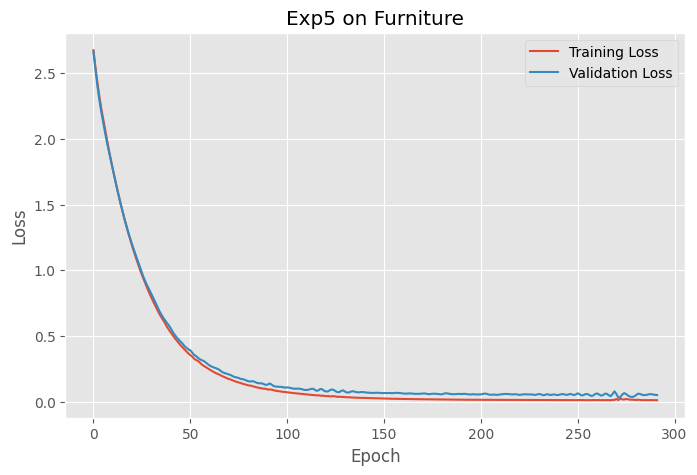

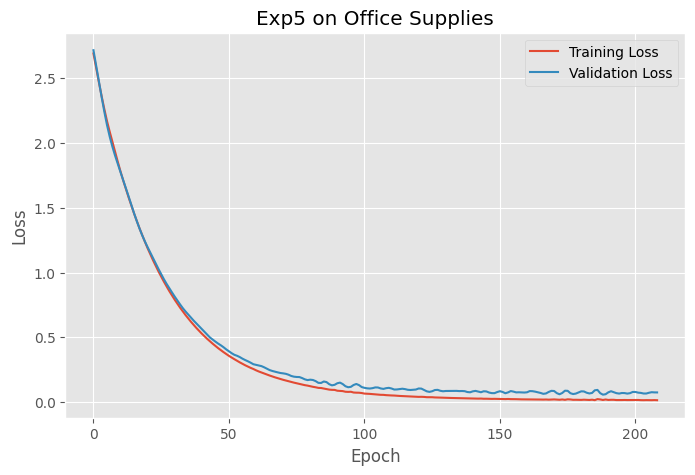

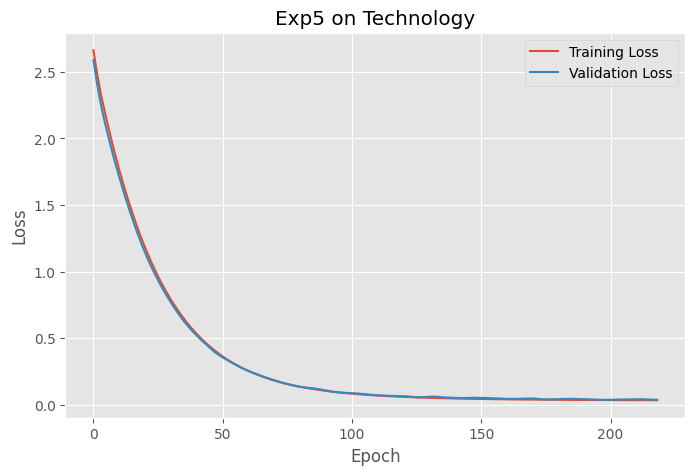

In [82]:
# Plot training and validation loss graphs, one for each category
plot_training_validation_loss(history5_f, '5', 'Exp5 on Furniture')
plot_training_validation_loss(history5_s, '5', 'Exp5 on Office Supplies')
plot_training_validation_loss(history5_t, '5', 'Exp5 on Technology')

In [83]:
# Predict Sales on TEST Data, for each category: Furniture, Office Supplies, Technology

p_sales_test5_f, y_sales_test5_f, rmse_test5_f = predict_sales(lstm_model_round5_f, X_test5_f, y_test5_f, minMaxScaler5_f)
print(f'Exp4: RMSE on TEST Data - Furniture: {rmse_test5_f}')

p_sales_test5_s, y_sales_test5_s, rmse_test5_s = predict_sales(lstm_model_round5_s, X_test5_s, y_test5_s, minMaxScaler5_s)
print(f'Exp4: RMSE on TEST Data - Office Supplies: {rmse_test5_s}')

p_sales_test5_t, y_sales_test5_t, rmse_test5_t = predict_sales(lstm_model_round5_t, X_test5_t, y_test5_t, minMaxScaler5_t)
print(f'Exp4: RMSE on TEST Data - Technology: {rmse_test5_t}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Exp4: RMSE on TEST Data - Furniture: 71.84376700905625
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Exp4: RMSE on TEST Data - Office Supplies: 108.82685311242463
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Exp4: RMSE on TEST Data - Technology: 128.8083013969569


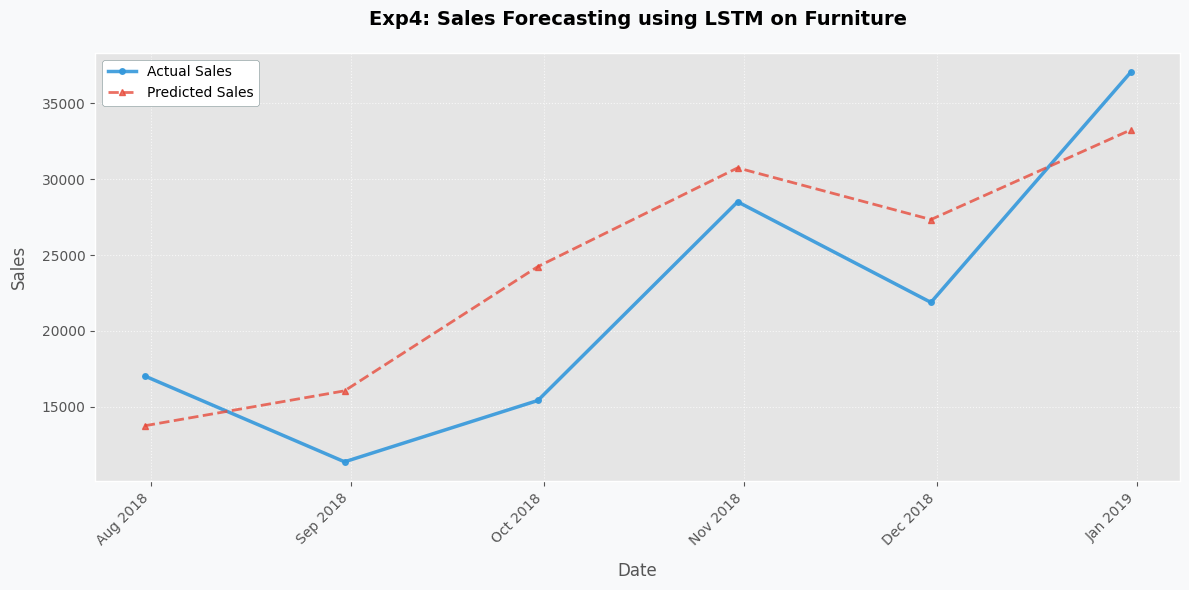

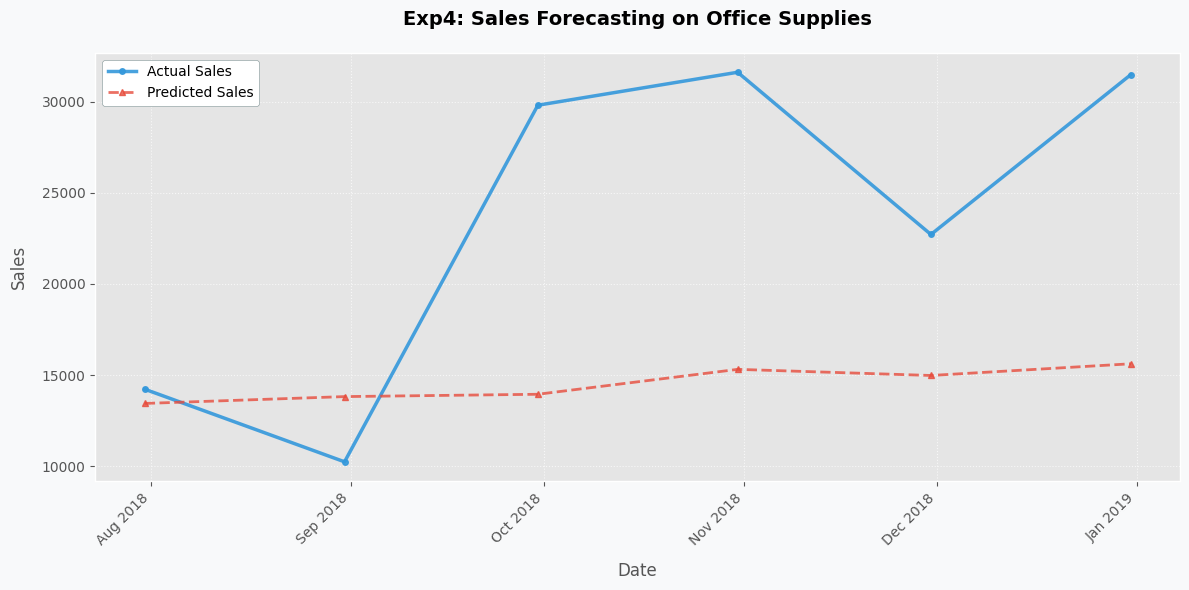

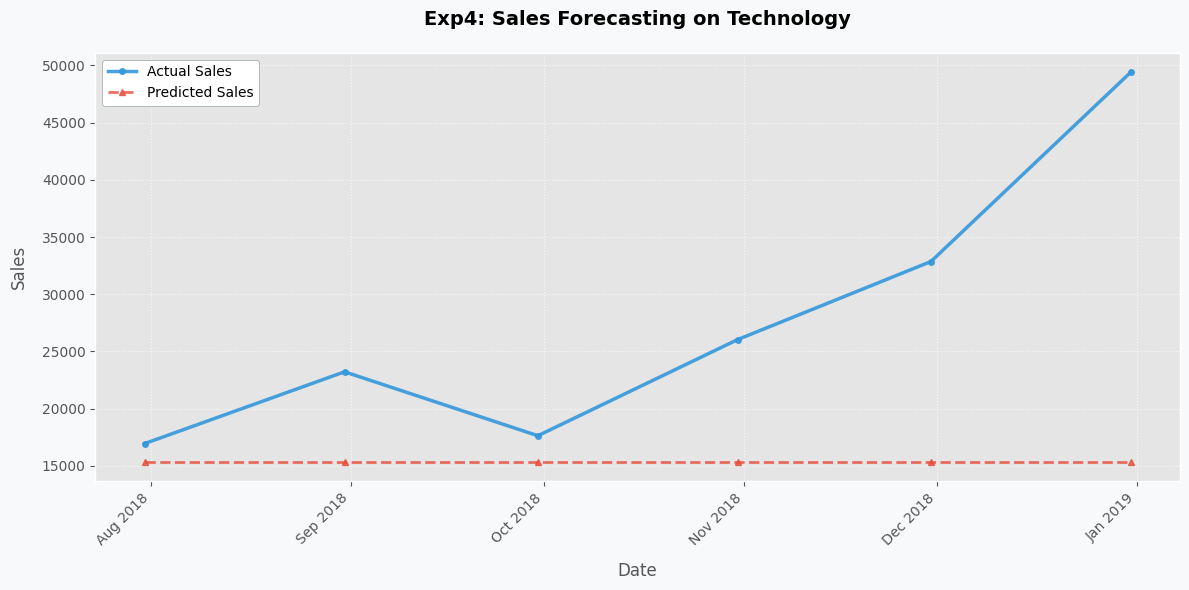

In [84]:
# Plot the results of prediction on TEST data, for each category
plot_testing_time_series_lstm(df_round5_f, 'Order Date', p_sales_test5_f, y_sales_test5_f, test_start,
                         'Exp4: Sales Forecasting using LSTM on Furniture',
                              mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)


plot_testing_time_series_lstm(df_round5_s, 'Order Date', p_sales_test5_s, y_sales_test5_s, test_start,
                         'Exp4: Sales Forecasting on Office Supplies',
                              mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)


plot_testing_time_series_lstm(df_round5_t, 'Order Date', p_sales_test5_t, y_sales_test5_t, test_start,
                         'Exp4: Sales Forecasting on Technology',
                              mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)

Experienment design 6: Enhanced Architecture & Hyperparameter Optimization​

​​Modeling & Evaluation - Round 6: Architecture & Hyperparameter Exploration​​
​​Network Architecture:​​

​​5 LSTM Layers​​ with descending neurons: ​​200 → 150 → 75 → 30 → 10​​
​​1 Dense Output Layer​​
​​Hyperparameter Variations:​​

​​Window Sizes:​​ Test ​​3-month​​ and ​​12-month​​ lookbacks
​​Optimizer:​​ Adam with different ​​learning rates​​ (e.g., 0.001, 0.0005, 0.0001)
​​Loss Function:​​ MSE
​​Regularization:​​
​​L1 (λ = 0.01)​​
​​L2 (λ = 0.05)​​
​​L2 (λ = 0.001)​​
​​Training:​​
​​Epochs:​​ 300
​​Early Stopping Patience:​​ 20

In [85]:
#For detailed explanation of the steps, see detailed comments on code cells in Round 1
df_round6 = df[['Order Date', 'Sales']]
df_round6 = df_round6.rename(columns={'Order Date': 'date', 'Sales': 'monthly_sales'})
df_round6.set_index('date', inplace = True)

In [86]:
# Group by monthly sales
df_round6 = df_round6.resample('ME')['monthly_sales'].sum().reset_index()

In [87]:
minMaxScaler6 = MinMaxScaler()
df_round6['monthly_sales'] = minMaxScaler6.fit_transform(df_round6[['monthly_sales']])

window = 12 #3
X6, y6 = create_sequences_for_lstm(df_round6['monthly_sales'], window)

In [88]:
# Split data into training, validation, and testing by the dates specified earlier.
X_train6, y_train6, X_validate6, y_validate6, X_test6, y_test6 = split(df_round6['date'], X6, y6, train_start, train_end, validate_start, validate_end, test_start, test_end, window)

# reshape the input arrays
X_train6, X_validate6, X_test6 = reshape(X_train6, X_validate6, X_test6)

In [102]:
lstm_model_round6 = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.005), input_shape=(12, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    LSTM(32, return_sequences=True, kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    LSTM(16, return_sequences=True, kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    LSTM(8, return_sequences=False, kernel_regularizer=l2(0.005)),
    Dense(4, activation='relu'),
    Dense(1)
])
lstm_model_round6.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
# Train the model
epochs6 = 300
batch_size6 = 12 #3 # 24
early_stopping_patience6 = 20
early_stopping6 = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience6, restore_best_weights=True, verbose=1)

history5 = lstm_model_round6.fit(X_train6, y_train6,
                                 epochs=epochs6,
                                 batch_size=batch_size6,
                                 validation_data=(X_validate6, y_validate6),
                                 callbacks=[early_stopping6],
                                 verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 1.7264 - val_loss: 1.7335
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.6444 - val_loss: 1.6445
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.5560 - val_loss: 1.5569
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.4920 - val_loss: 1.4721
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.4254 - val_loss: 1.3945
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.3655 - val_loss: 1.3281
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.3044 - val_loss: 1.2716
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.2584 - val_loss: 1.2215
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.2135 - val_loss: 1.1747
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1600 - val_loss: 1.1316
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.1167 - val_loss: 1.0930
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.0703 - 

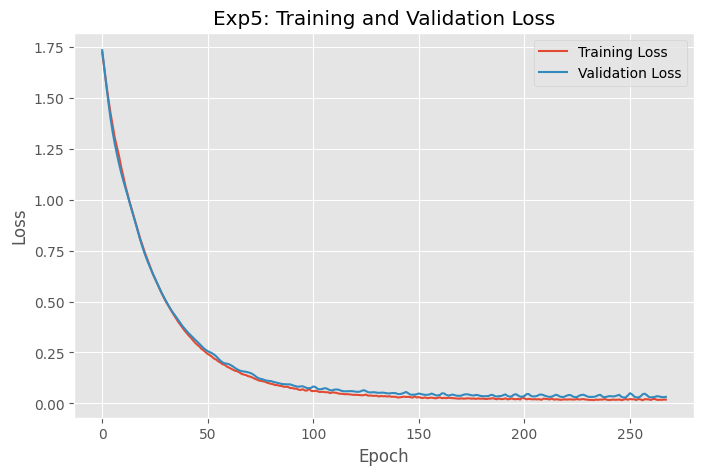

In [104]:
# Plot training and validation loss graph
plot_training_validation_loss(history5, '5')

In [105]:
# Predict Sales on TRAINING Data, then on VALIDATION Data, then on TEST Data

p_sales_training6, y_sales_training6, rmse_training6 = predict_sales(lstm_model_round6, X_train6, y_train6, minMaxScaler6)
p_sales_validation6, y_sales_validation6, rmse_validation6 = predict_sales(lstm_model_round6, X_validate6, y_validate6, minMaxScaler6)
p_sales_test6, y_sales_test6, rmse_test6 = predict_sales(lstm_model_round6, X_test6, y_test6, minMaxScaler6)

print()
print(f'Ex5 RMSE score on TRAINING Data: {rmse_training6}')
print(f'Exp5 RMSE score on VALIDATION Data: {rmse_validation6}')
print(f'Exp5 RMSE score on TEST Data: {rmse_test6}')
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Ex5 RMSE score on TRAINING Data: 121.34508612449994
Exp5 RMSE score on VALIDATION Data: 132.6930383868417
Exp5 RMSE score on TEST Data: 157.93975999343726



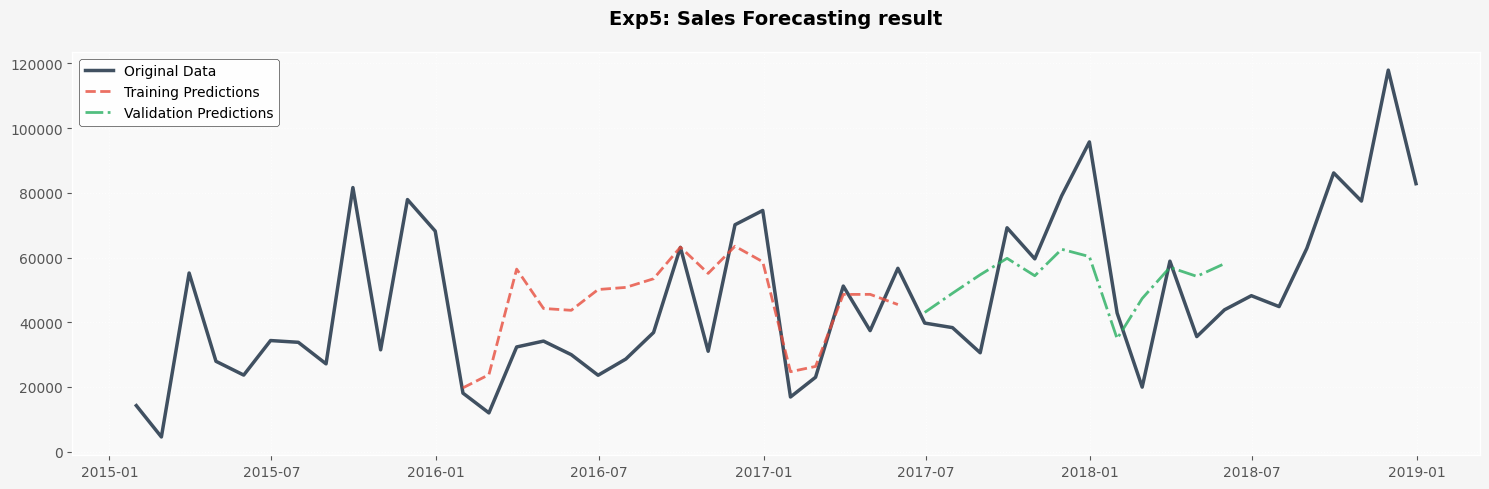

In [106]:
# Plot the results of prediction on TRAINING data and VALIDATION data
title = 'Exp5: Sales Forecasting result'
plot_training_and_validation_time_series_lstm(df_round6, 'date', 'monthly_sales', p_sales_training6, p_sales_validation6, minMaxScaler6, title)

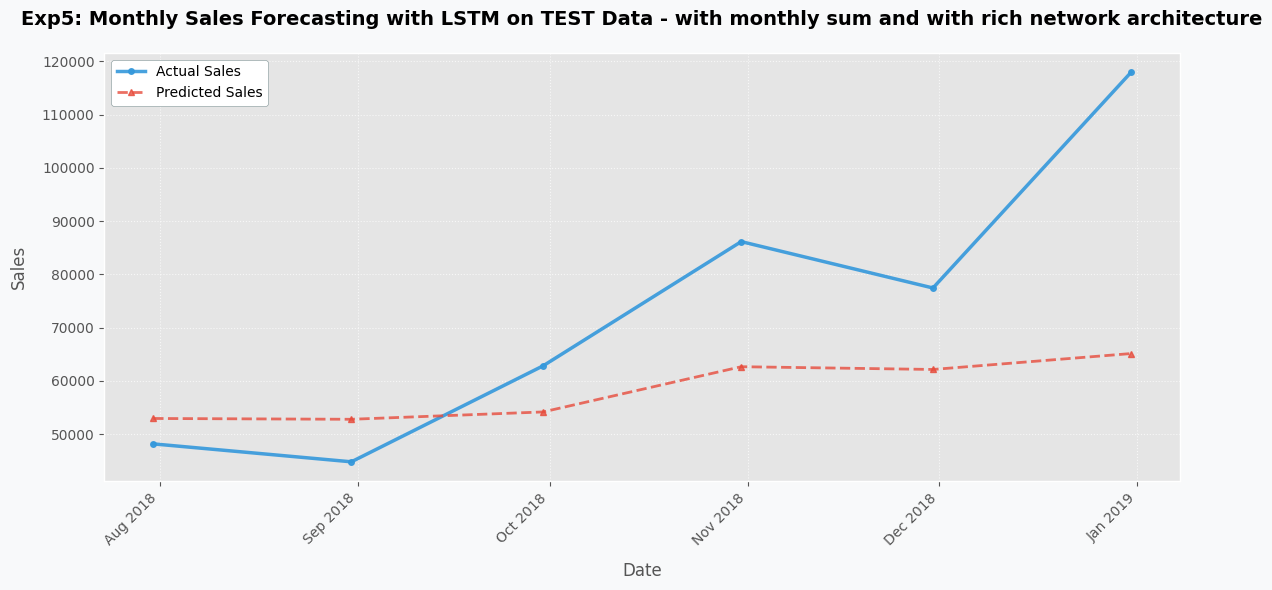

In [107]:
# Plot the results of prediction on TEST data
title = 'Exp5: Monthly Sales Forecasting with rich network architecture'
plot_testing_time_series_lstm(df_round6, 'date', p_sales_test6, y_sales_test6, test_start, title, mdates.MonthLocator(), mdates.DateFormatter('%b %Y'), 45)

This version attempted various hyperparameter settings, with solid RMSE improvements​​—but the result reiterates that ​​forecast accuracy decreases with diminishing returns​​ based on our current dataset.

Key Takeaways:

Limited Accuracy Potential
Time-series forecasting inherently carries uncertainty due to:
Unpredictable external factors
Natural variation in sales patterns
Slower networks further minimizing mistakes ​​won't make much of a difference​​
Architecture Adequacy
The current ​​5-layer LSTM​​ is sufficiently deep
Adding layers/additional complexity would be at risk of ​​overfitting without material gains​​
Future Directions
Shift focus from architecture tweaks to
​​Feature engineering​​ (e.g., external regressors like promotions, holidays)
​​Alternative approaches​​ (e.g., ensemble methods, hybrid models)
Accept that ​​some forecast error is unavoidable​​
​​Conclusion:​​
While hyperparameter tuning provided incremental gains, ​​diminishing returns suggest we’ve reached the dataset’s predictive limits​​ with this architecture. Future efforts should explore complementary strategies rather than deeper networks.